# Final project - FDS
The first code block retrives the images, and then does the preprocessing stages of converting to grayscale, making shure all the images are the same size and normalizes the grayscale values. 

In [57]:
import sys
!{sys.executable} -m pip install matplotlib numpy pillow

!{sys.executable} -m pip install scikit-learn

!{sys.executable} -m pip install tensorflow   # if needed
# or
!{sys.executable} -m pip install torch torchvision   # if using pytorch

!{sys.executable} -m pip install tqdm


In [58]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to collect all images from a folder (including subfolders)
def collect_images_from_folder(folder_path):
    image_paths = []
    # Walk through all subfolders and gather image file paths
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            image_paths.append(os.path.join(root, file))
    return image_paths

# This preprocessing is now obselite and not usable bc. were using ResNet50
# Function to preprocess the images (resize, grayscale, and normalize)
def preprocess_images(image_paths, image_size=(128, 128)):
    processed_images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize(image_size)  # Resize
        img_array = np.array(img_resized) / 255.0  # Normalize to [0, 1]
        processed_images.append(img_array)
    return np.array(processed_images)

# Extracting all the lables from the dataset
def extract_labels(image_paths):
    """Extracts labels from the parent folder names."""
    labels = []
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)
    return np.array(labels)

# Collect all image paths
train_folder = "intel-image-classification/seg_train"
test_folder  = "intel-image-classification/seg_test"
pred_folder  = "intel-image-classification/seg_pred" 

train_paths = collect_images_from_folder(train_folder)
test_paths  = collect_images_from_folder(test_folder)

print("Train samples:", len(train_paths))
print("Test samples:", len(test_paths))

# Extract lables
y_train = extract_labels(train_paths)
y_test  = extract_labels(test_paths)

print("Train labels:", np.unique(y_train))
print("Test labels:", np.unique(y_test))

#Preprocessing the images
X_train = preprocess_images(train_paths)
X_test  = preprocess_images(test_paths)

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train samples: 14034
Test samples: 3000
Train labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Test labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Train data shape: (14034, 128, 128)
Test data shape: (3000, 128, 128)


### Displaying the different images preprocessed:

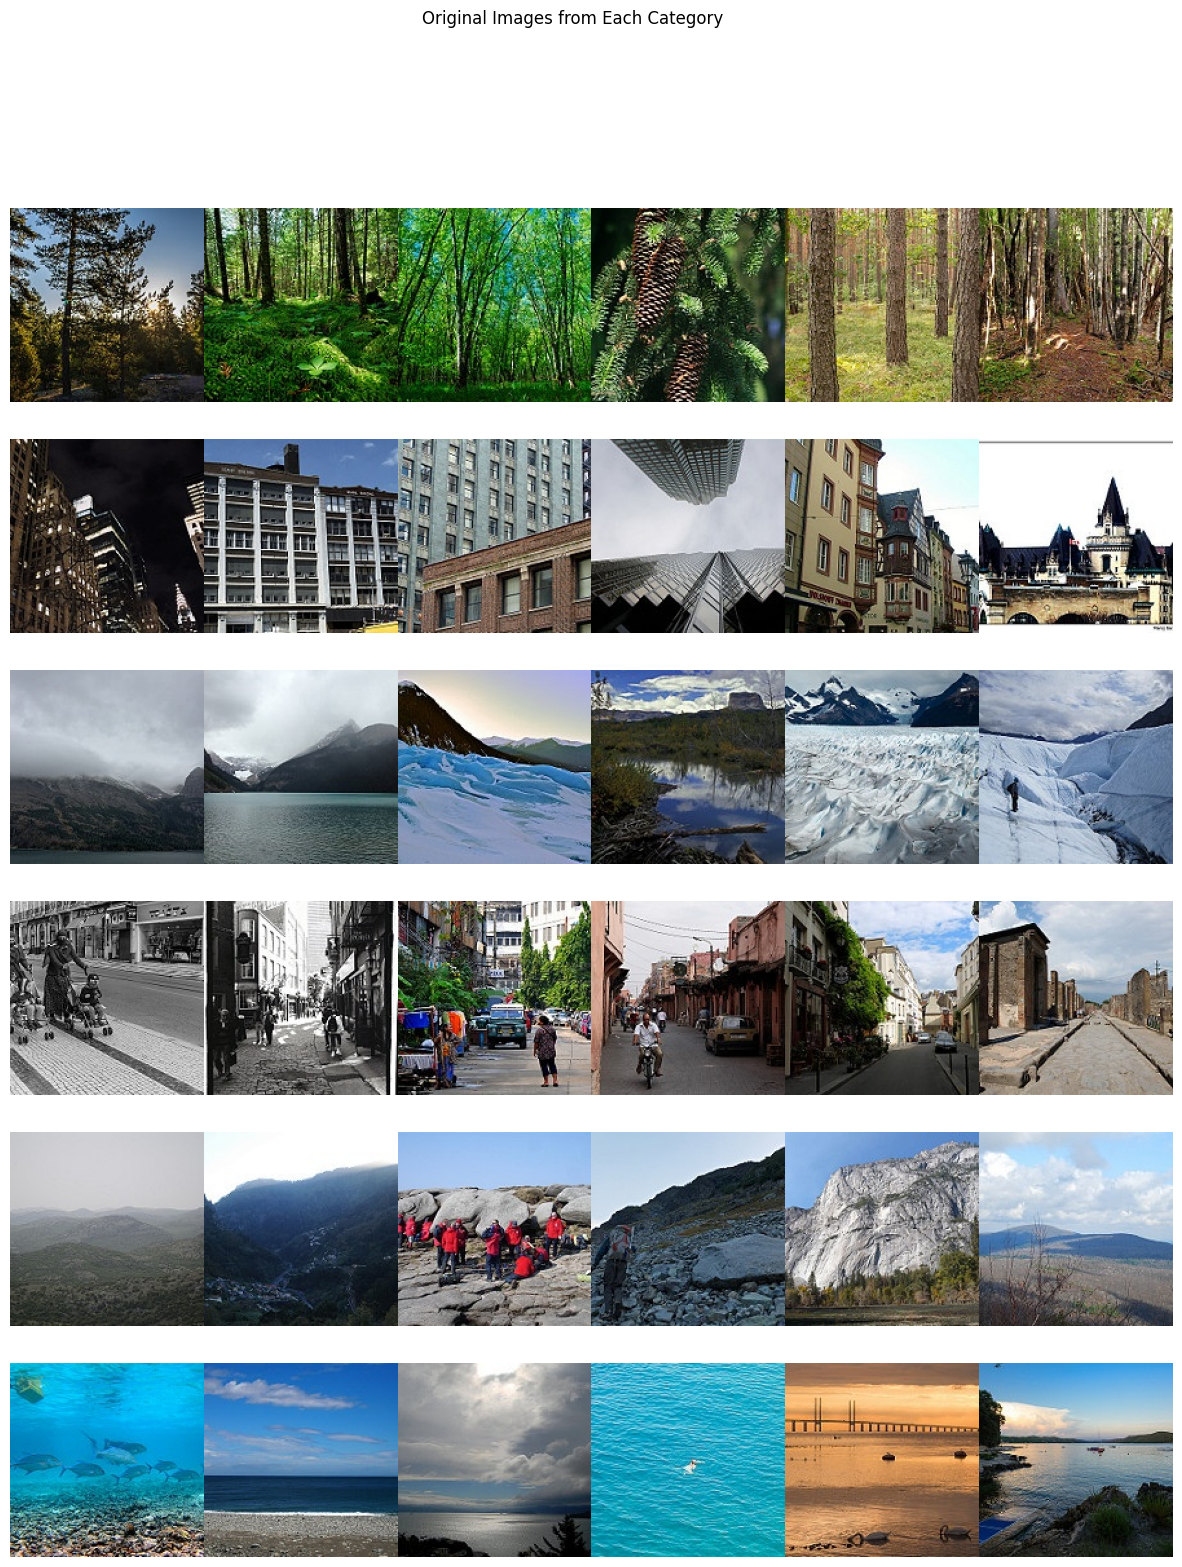

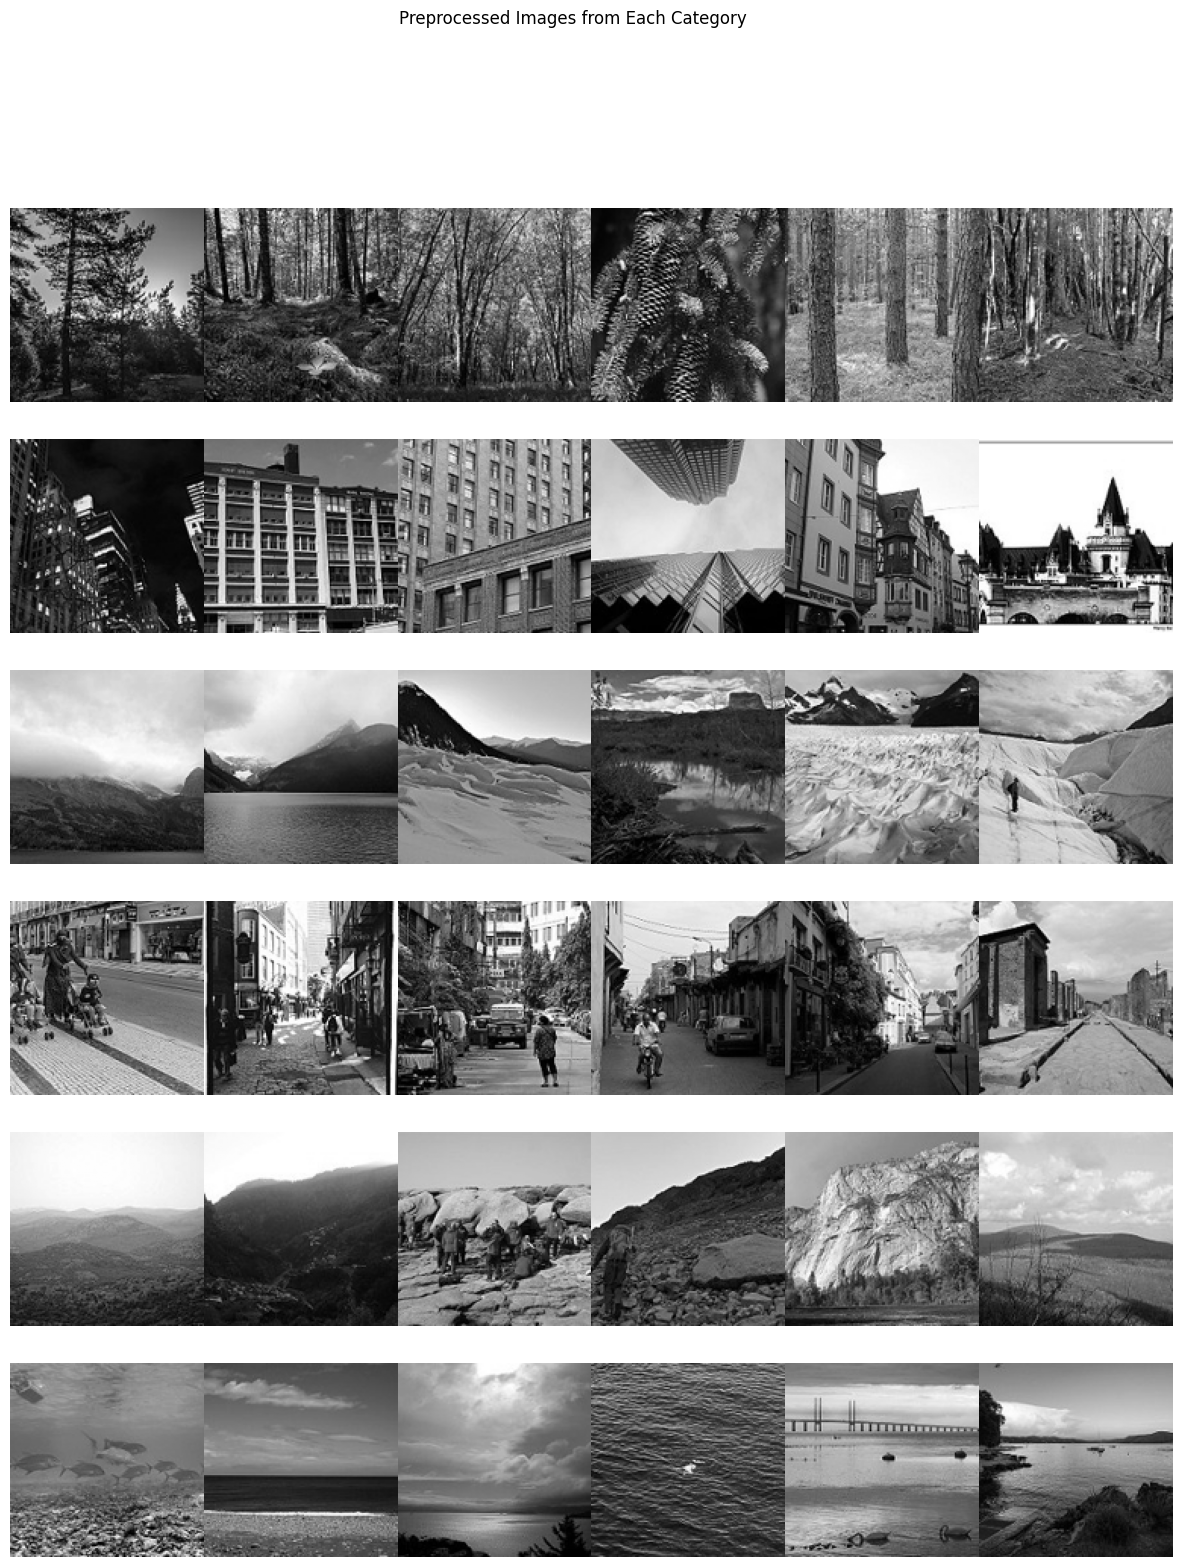

In [59]:
from collections import defaultdict

# Function to collect images from each category folder (6 images per category)
def collect_images_from_categories(folder_path, images_per_category=6):
    category_images = defaultdict(list)
    # Walk through subfolders and collect images by category
    for root, dirs, files in os.walk(folder_path):
        category = os.path.basename(root)  # Use subfolder name as category
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                if len(category_images[category]) < images_per_category:
                    category_images[category].append(os.path.join(root, file))
    return category_images

category_images = collect_images_from_categories(train_folder)

images_per_category = 6
num_categories = len(category_images)

fig, axs = plt.subplots(
    num_categories, 
    images_per_category,
    figsize=(15, 3 * num_categories),
    gridspec_kw={'wspace': 0, 'hspace': 0}
)

for i, (category, images) in enumerate(category_images.items()):
    for j in range(images_per_category):
        axs[i][j].axis('off')
        if j < len(images):
            img = Image.open(images[j])
            axs[i][j].imshow(img)
            
plt.suptitle("Original Images from Each Category")
plt.show()

fig, axs = plt.subplots(
    num_categories, 
    images_per_category,
    figsize=(15, 3 * num_categories),
    gridspec_kw={'wspace': 0, 'hspace': 0}
)

for i, (category, images) in enumerate(category_images.items()):
    processed_images = preprocess_images(images[:images_per_category])
    
    for j in range(images_per_category):
        axs[i][j].axis('off')
        if j < len(processed_images):
            axs[i][j].imshow(processed_images[j], cmap='gray')

plt.suptitle("Preprocessed Images from Each Category")
plt.show()

### Feature extraction

Since the data we are using has a high dimentionality due to beeing images we decided to use PCA to reduce the number of dimentions. 

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from PIL import Image

IMG_SIZE = 224   # Required for ResNet50

# Load pretrained ResNet50
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

feature_extractor = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()    # Output: 2048 features
])

feature_extractor.trainable = False

print("ResNet50 feature extractor ready.")

# Load + preprocess image for ResNet
def load_and_preprocess_resnet(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype(np.float32)
    img = preprocess_input(img)  # ImageNet normalization
    return img

# Extract features in batches
def extract_resnet_features(image_paths, batch_size=32):
    features = []

    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting ResNet features"):
        batch_paths = image_paths[i : i + batch_size]
        batch_images = np.array([load_and_preprocess_resnet(p) for p in batch_paths])
        batch_features = feature_extractor(batch_images, training=False)
        features.append(batch_features.numpy())

    return np.concatenate(features, axis=0)


# Run feature extraction
print("\nExtracting TRAIN features...")
X_train_resnet = extract_resnet_features(train_paths)

print("\nExtracting TEST features...")
X_test_resnet = extract_resnet_features(test_paths)

print("\nFeature shapes:")
print("X_train_resnet:", X_train_resnet.shape)  # (n_train, 2048)
print("X_test_resnet :", X_test_resnet.shape)   # (n_test, 2048)


ResNet50 feature extractor ready.

Extracting TRAIN features...


Extracting ResNet features: 100%|██████████| 439/439 [18:06<00:00,  2.48s/it]



Extracting TEST features...


Extracting ResNet features: 100%|██████████| 94/94 [03:58<00:00,  2.54s/it]


Feature shapes:
X_train_resnet: (14034, 2048)
X_test_resnet : (3000, 2048)


Computing FAST PCA with max 300 components...
Components needed for 80% variance: 108
Variance retained: 0.8001


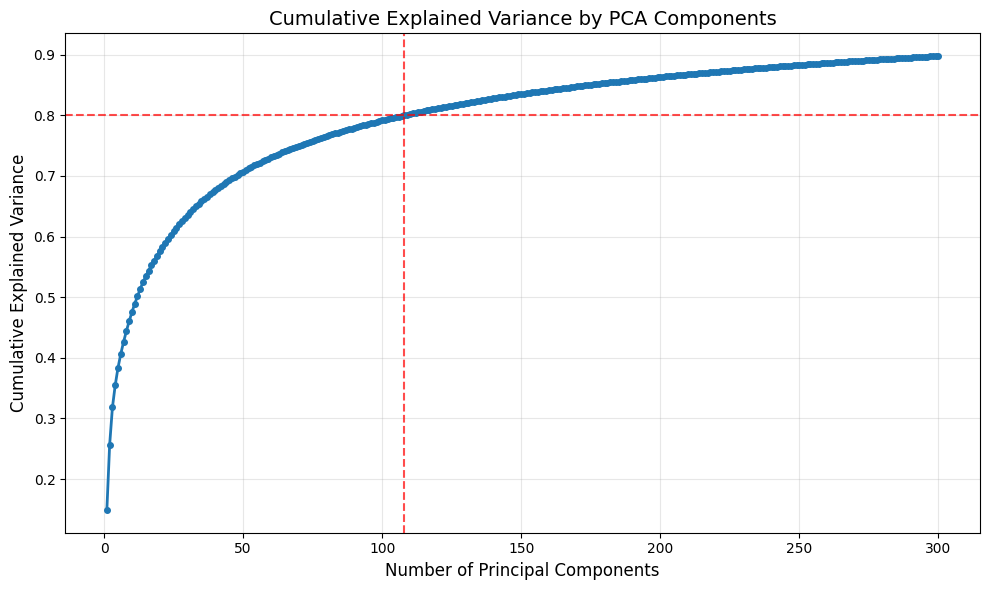

Train PCA shape: (14034, 108)
Test PCA shape: (3000, 108)


In [49]:
from sklearn.decomposition import PCA

# flatten features
X_train_flat = X_train_resnet.reshape(X_train_resnet.shape[0], -1)
X_test_flat  = X_test_resnet.reshape(X_test_resnet.shape[0], -1)

n_samples, n_features = X_train_flat.shape

# limit PCA to at most 300 components for speed
MAX_COMPONENTS = min(300, n_samples, n_features)

print(f"Computing FAST PCA with max {MAX_COMPONENTS} components...")

# very fast and scalable PCA (randomized SVD)
pca_fast = PCA(
    n_components=MAX_COMPONENTS,
    svd_solver="randomized",
    random_state=42
)

pca_fast.fit(X_train_flat)

# cumulative explained variance
cumulative_var = np.cumsum(pca_fast.explained_variance_ratio_)

# number of components needed for 80% variance
n_components_80 = np.argmax(cumulative_var >= 0.80) + 1
print(f"Components needed for 80% variance: {n_components_80}")
print(f"Variance retained: {cumulative_var[n_components_80 - 1]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var) + 1),
         cumulative_var, 
         'o-', linewidth=2, markersize=4)

plt.axhline(y=0.80, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axvline(x=n_components_80, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# final PCA model using only the required components
pca = PCA(
    n_components=n_components_80,
    svd_solver="randomized",
    random_state=42
)
pca.fit(X_train_flat)

# Transform sets
X_train_pca = pca.transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np

# Train the random forest classifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf.fit(X_train_resnet, y_train)

# Evaluate the model 

y_pred = rf.predict(X_test_resnet)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Train the SVM and compare with random forest

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svm = SVC(
    kernel='rbf',
    C=5,
    gamma='scale'
)

svmlin = LinearSVC(
    C=5
)

print("Training SVM...")
svm.fit(X_train_resnet, y_train)

#Evaluate the model

y_pred = svm.predict(X_test_resnet)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


print("Trying another kernel")
print("Training linear SVM...")
svmlin.fit(X_train_resnet, y_train)

#Evaluate the model

y_pred = svmlin.predict(X_test_resnet)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Training Random Forest...

Accuracy: 0.9153333333333333

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.85      0.86      0.85       553
    mountain       0.88      0.83      0.85       525
         sea       0.94      0.98      0.96       510
      street       0.91      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.91      0.92      0.91      3000

Training SVM...
Accuracy: 0.9426666666666667
              precision    recall  f1-score   support

   buildings       0.95      0.94      0.94       437
      forest       1.00      1.00      1.00       474
     glacier       0.91      0.88      0.89       553
    mountain       0.89      0.91      0.90       525
         sea       0.96      0.99      0.97       510
      s

### Trying to fine tune the top layers of ResNet50

Encode lables and use Keras

In [60]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)

y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

print("Classes:", le.classes_)


Classes: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Load dataset using Tensorflow

In [61]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = 224

def load_dataset(image_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
    def generator():
        for path, label in zip(image_paths, labels):
            img = load_and_preprocess_resnet(path)
            yield img, label

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
        )
    )

    if shuffle:
        ds = ds.shuffle(1000)

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = load_dataset(train_paths, y_train_cat)
test_ds  = load_dataset(test_paths, y_test_cat, shuffle=False)


Build ResNet50, frozen base

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(base_model.input, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train only the classification head

In [63]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)


Epoch 1/5
    439/Unknown 396s 888ms/step - accuracy: 0.9630 - loss: 0.3423

2025-12-23 16:21:28.920055: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Caskroom/miniconda/base/envs/tdt4300/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


439/439 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9629 - loss: 0.2527 - val_accuracy: 0.5973 - val_loss: 2.5134
Epoch 2/5


2025-12-23 16:22:52.695104: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.9748 - loss: 0.1037 - val_accuracy: 0.6653 - val_loss: 1.8426
Epoch 3/5


2025-12-23 16:30:57.320605: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.9792 - loss: 0.0797 - val_accuracy: 0.7323 - val_loss: 1.0090
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.9805 - loss: 0.0825 - val_accuracy: 0.7360 - val_loss: 1.1786
Epoch 5/5


2025-12-23 16:47:06.496469: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.9803 - loss: 0.0810 - val_accuracy: 0.7327 - val_loss: 1.4885


Unfreeze top ResNet layers

In [66]:
# Unfreeze top layers ONLY
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Recompile with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 16,883,974 (64.41 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

Fine tune the network and evaluate

In [67]:
fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

loss, acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {acc:.4f}")


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 927s 2s/step - accuracy: 0.7310 - loss: 0.7200 - val_accuracy: 0.7430 - val_loss: 0.7356
Epoch 2/5


2025-12-23 17:39:14.394773: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - accuracy: 0.7736 - loss: 0.6065 - val_accuracy: 0.7573 - val_loss: 0.8336
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 781s 2s/step - accuracy: 0.8323 - loss: 0.4653 - val_accuracy: 0.7613 - val_loss: 0.8576
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.8879 - loss: 0.3476 - val_accuracy: 0.7520 - val_loss: 1.0448
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.9215 - loss: 0.2573 - val_accuracy: 0.7273 - val_loss: 1.3348
94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 912ms/step - accuracy: 0.7273 - loss: 1.3348
Final Test Accuracy: 0.7273
